In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from bs4 import BeautifulSoup
import seaborn as sns
from statsmodels.nonparametric.kernel_regression import KernelReg

In [101]:
prices_data = pd.read_csv("prices_data.csv")
house_features = pd.read_csv("house_features.csv")
metro_data = pd.read_csv("metro_data.csv")

merged_table = pd.read_csv("merged_table.csv")

In [102]:
merged_table.head()

,value,reportDate,prettyValue,realty_id,Адрес,URL,Год постройки,Тип дома,Этажность,Строительная серия,...,Ближайшая станция до тритмента расстояние,Ближайшая станция до тритмента,Сокращение расстояния,Number of queries,all_goods_cpi,rent_cpi,cum_goods_cpi,cum_rent_cpi,cumprod,discounted_value
0,220493.0,2020-03-01,220 493 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2370.0,Беляево,1489.0,145.0,1.0048,1.0,1.012047,1.0,1.0,220493.0
1,174608.0,2020-03-01,174 608 ₽/м²,99,"Москва, улица Академика Арцимовича, 2К2",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1967,Панельный,9,1605-АМ,...,1050.0,Беляево,387.0,145.0,1.0048,1.0,1.012047,1.0,1.0,174608.0
2,245710.0,2020-03-01,245 710 ₽/м²,13,"Москва, улица Островитянова, 9К4",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2001,Монолитный,17,П-44Т,...,1937.0,Коньково,877.0,145.0,1.0048,1.0,1.012047,1.0,1.0,245710.0
3,163029.0,2020-03-01,163 029 ₽/м²,85,"Москва, пос. Завода Мосрентген, улица Героя Ро...",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1980,Панельный,12,Индивидуальный проект,...,2938.0,Корниловская,1760.0,145.0,1.0048,1.0,1.012047,1.0,1.0,163029.0
4,183429.0,2020-03-01,183 429 ₽/м²,51,"Москва, улица Академика Варги, 28",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1974,NaN,9,NaN,...,1601.0,Тропарёво,117.0,145.0,1.0048,1.0,1.012047,1.0,1.0,183429.0


## LPR

In [103]:
merged_table_lpr = merged_table[merged_table["reportDate"] >= "2021-06-01"].copy()  
merged_table_lpr.loc[:, "log_discounted_value"] = np.log(merged_table_lpr["discounted_value"])

In [104]:
merged_table_lpr['post'] = (merged_table_lpr['reportDate'] > '2024-09-01').astype(int)
lpr_data = merged_table_lpr.groupby(["post", "Сокращение расстояния"])["log_discounted_value"].median().reset_index()

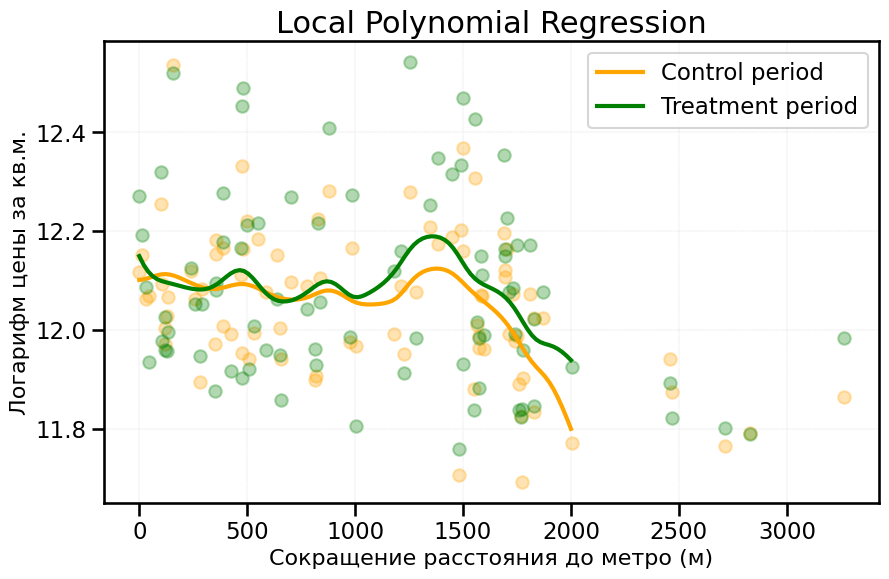

In [105]:
import seaborn as sns

lpr_before = lpr_data[lpr_data["post"] == 0]
lpr_after = lpr_data[lpr_data["post"] == 1]

def local_poly_regression(lpr_data, color, label):
    kr = KernelReg(
        endog=lpr_data["log_discounted_value"], 
        exog=lpr_data["Сокращение расстояния"], 
        var_type='c', 
        reg_type='ll',  
        bw=[100]
    )
    
    distance_range = np.linspace(0, 2000, 100) 
    predicted_log_price, _ = kr.fit(distance_range)  
    
    plt.scatter(lpr_data["Сокращение расстояния"], lpr_data["log_discounted_value"], alpha=0.3, color=color, marker="o") 
    plt.plot(distance_range, predicted_log_price, color=color, label=label, linewidth=3)
sns.set_context("talk") #paper notebook  talk poster
plt.figure(figsize=(10, 6))

local_poly_regression(lpr_before, color="orange", label="Control period")
local_poly_regression(lpr_after, color="green", label="Treatment period")

plt.xlabel("Сокращение расстояния до метро (м)", fontsize=16)
plt.ylabel("Логарифм цены за кв.м.", fontsize=16)
plt.title("Local Polynomial Regression", fontsize=22)
plt.legend()
plt.grid(True, linestyle=":", linewidth=0.3)
plt.savefig("LPR", dpi=300)
plt.show()


## Корреляционная матрица

In [114]:
merged_table.head()

,value,reportDate,prettyValue,realty_id,Адрес,URL,Год постройки,Тип дома,Этажность,Строительная серия,...,Название первой станции,Название второй станции,Название третьей станции,Ближайшая станция после тритмента расстояние,Ближайшая станция после тритмента,Ближайшая станция до тритмента расстояние,Ближайшая станция до тритмента,Сокращение расстояния,Number of queries,cpi
0,220493.0,2020-03-01,220 493 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,145.0,1.0037
1,228764.0,2020-04-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,104.0,1.0065
2,228764.0,2020-05-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,89.0,1.0043
3,239315.0,2020-06-01,239 315 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,140.0,1.0035
4,236383.0,2020-07-01,236 383 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,285.0,1.0028


In [115]:
corr_table = merged_table[['value',
       'Год постройки', 
    #  'Тип дома', 
       'Этажность', 
    #'Строительная серия',
    # 'Высота потолков', 
   #  'Газоснабжение', 
   #   'Отопление', 
   #   'Тип перекрытий',
   #   'Подъездов', 
   #   'Количество лифтов', 
   # 'Мусоропроводов', 
        'Квартир',
   #  'Реновация', 'Аварийность', 
     # 'Детская площадка',
       "Спортивная площадка",
    #   'Фонд капитального ремонта', 
    #    'Расстояние до первой станции',
    #    'Расстояние до второй станции', 'Расстояние до третьей станции',
    #    'Название первой станции', 'Название второй станции',
    #    'Название третьей станции',
    #   'Ближайшая станция после тритмента расстояние',
    #    'Ближайшая станция после тритмента',
    #   'Ближайшая станция до тритмента расстояние',
    #    'Ближайшая станция до тритмента', 
       'Сокращение расстояния', 'post',
       'Number of queries']]

cat_columns = corr_table.select_dtypes(include=[object]).columns


# One-Hot Encoding
corrr_table_encoded = pd.get_dummies(corr_table, columns=cat_columns)

KeyError: "['post'] not in index"

In [ ]:
corr_matrix = corrr_table_encoded.corr()
corr_matrix


,value,Год постройки,Этажность,Квартир,Сокращение расстояния,post,Number of queries,Спортивная площадка_Да,Спортивная площадка_Нет
value,1.000000,0.379634,0.352879,0.089407,-0.258955,0.153509,0.276204,0.201415,-0.201415
Год постройки,0.379634,1.000000,0.459051,0.205709,0.102721,-0.016256,-0.024164,0.173788,-0.173788
Этажность,0.352879,0.459051,1.000000,0.309299,-0.158295,-0.005486,-0.003720,0.132066,-0.132066
Квартир,0.089407,0.205709,0.309299,1.000000,-0.050710,-0.021597,-0.008093,0.287842,-0.287842
Сокращение расстояния,-0.258955,0.102721,-0.158295,-0.050710,1.000000,0.014815,0.007173,-0.125807,0.125807
post,0.153509,-0.016256,-0.005486,-0.021597,0.014815,1.000000,0.295611,-0.020161,0.020161
Number of queries,0.276204,-0.024164,-0.003720,-0.008093,0.007173,0.295611,1.000000,-0.005240,0.005240
Спортивная площадка_Да,0.201415,0.173788,0.132066,0.287842,-0.125807,-0.020161,-0.005240,1.000000,-1.000000
Спортивная площадка_Нет,-0.201415,-0.173788,-0.132066,-0.287842,0.125807,0.020161,0.005240,-1.000000,1.000000


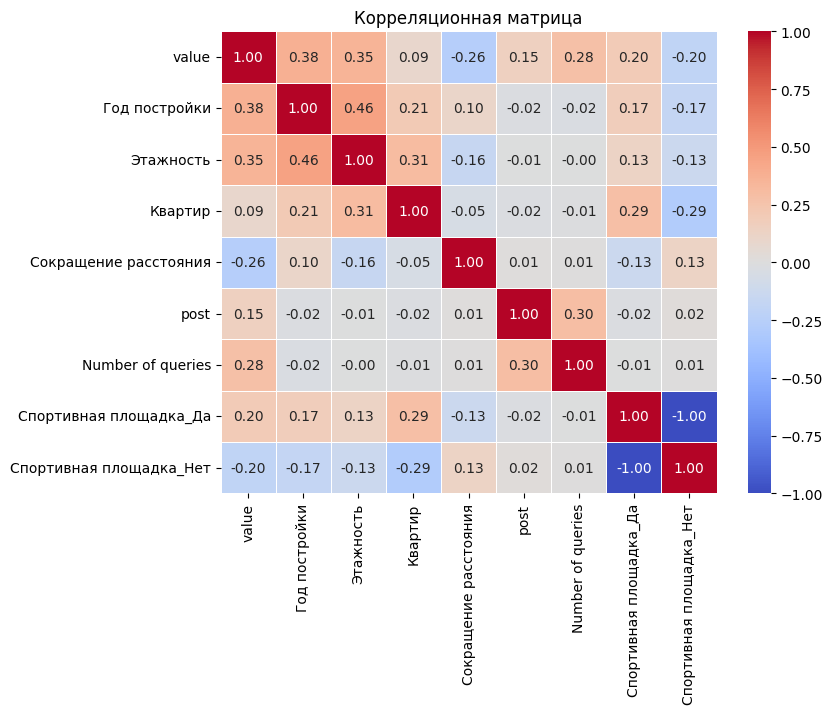

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица")
plt.show()

In [ ]:
corr_matrix['value'][abs(corr_matrix['value']) > 0.2].sort_values(ascending=False)


value                                                         1.000000
Высота потолков                                               0.429857
Тип дома_Монолитный                                           0.404049
Год постройки                                                 0.379634
Этажность                                                     0.352879
Number of queries                                             0.276204
Количество лифтов_20 пассажирских                             0.227662
Спортивная площадка_Да                                        0.201415
Спортивная площадка_Нет                                      -0.201415
Фонд капитального ремонта_На счете регионального оператора   -0.222685
Сокращение расстояния                                        -0.258955
Name: value, dtype: float64

In [ ]:
corr_matrix["value"].sort_values(ascending=False)

In [ ]:
merged_table.head()

,value,reportDate,prettyValue,realty_id,Адрес,URL,Год постройки,Тип дома,Этажность,Строительная серия,...,Расстояние до второй станции,Расстояние до третьей станции,Название первой станции,Название второй станции,Название третьей станции,Ближайшая станция после тритмента расстояние,Ближайшая станция после тритмента,Ближайшая станция до тритмента расстояние,Ближайшая станция до тритмента,Сокращение расстояния
0,220493.0,2020-03-01,220 493 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2370.0,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0
1,228764.0,2020-04-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2370.0,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0
2,228764.0,2020-05-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2370.0,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0
3,239315.0,2020-06-01,239 315 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2370.0,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0
4,236383.0,2020-07-01,236 383 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2370.0,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0


## Wordstat

In [ ]:
queries = pd.read_csv("wordstat_dynamic.csv", sep=";").drop(columns = 'Frequency dynamics for «троицкая линия метро», by month, 01.03.2020 — 31.01.2025, all regions, all devices')
queries["Number of queries"] = (
    queries["Number of queries"]
    .astype(str)       # Преобразуем в строку (на всякий случай)
    .str.replace(" ", "")  # Убираем все пробелы
    .astype(float)     # Преобразуем обратно в float
)

queries["Period"] = pd.to_datetime(queries["Period"]).dt.date

queries.rename(columns={"Period":"reportDate"}, inplace=True)

queries.head()

/tmp/ipykernel_2812/3377209436.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  queries["Period"] = pd.to_datetime(queries["Period"]).dt.date


,reportDate,Number of queries,"Percentage of total queries, %"
0,2020-03-01,145.0,"0,00000148"
1,2020-04-01,104.0,"0,00000087"
2,2020-05-01,89.0,"0,00000083"
3,2020-06-01,140.0,"0,00000157"
4,2020-07-01,285.0,"0,00000340"


In [ ]:
queries.head()

,reportDate,Number of queries,"Percentage of total queries, %"
0,2020-03-01,145.0,"0,00000148"
1,2020-04-01,104.0,"0,00000087"
2,2020-05-01,89.0,"0,00000083"
3,2020-06-01,140.0,"0,00000157"
4,2020-07-01,285.0,"0,00000340"


In [ ]:
# fig, ax = plt.subplots(figsize=(10, 5))

# ax.plot(queries["Period"], queries["Number of queries"])
# plt.show()

In [ ]:
merged_table["reportDate"] = pd.to_datetime(merged_table["reportDate"])
queries["reportDate"] = pd.to_datetime(queries["reportDate"])

merged_table = merged_table.merge(queries[["reportDate", "Number of queries"]], on ="reportDate", how="left")
merged_table.reportDate = merged_table.reportDate.dt.date

In [ ]:
merged_table.head()

,value,reportDate,prettyValue,realty_id,Адрес,URL,Год постройки,Тип дома,Этажность,Строительная серия,...,Расстояние до третьей станции,Название первой станции,Название второй станции,Название третьей станции,Ближайшая станция после тритмента расстояние,Ближайшая станция после тритмента,Ближайшая станция до тритмента расстояние,Ближайшая станция до тритмента,Сокращение расстояния,Number of queries
0,220493.0,2020-03-01,220 493 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,145.0
1,228764.0,2020-04-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,104.0
2,228764.0,2020-05-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,89.0
3,239315.0,2020-06-01,239 315 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,140.0
4,236383.0,2020-07-01,236 383 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,285.0


In [99]:
merged_table.to_csv("merged_table.csv", index=False)

## CPI

In [176]:
cpi = pd.read_csv("rent_goods_cpi.csv", sep=";")

In [178]:
months = {
    'январь': '01', 'февраль': '02', 'март': '03', 'апрель': '04',
    'май': '05', 'июнь': '06', 'июль': '07', 'август': '08',
    'сентябрь': '09', 'октябрь': '10', 'ноябрь': '11', 'декабрь': '12'
}

# Создание нового столбца с датой
cpi['reportDate'] = cpi['year'].astype(str) + '-' + cpi['month'].map(months) + '-01'

# Преобразование в формат datetime (по желанию)
cpi['reportDate'] = pd.to_datetime(cpi['reportDate']).dt.date

In [179]:
cpi

,year,month,All_goods,rent_2rooms_per_month,reportDate
0,2020,январь,"100,45",100,2020-01-01
1,2020,февраль,"100,27",100,2020-02-01
2,2020,март,"100,48",100,2020-03-01
3,2020,апрель,"100,65",100,2020-04-01
4,2020,май,"100,43",100,2020-05-01
...,...,...,...,...,...
56,2024,сентябрь,"100,38","100,44",2024-09-01
57,2024,октябрь,"100,81","101,77",2024-10-01
58,2024,ноябрь,"101,48","99,51",2024-11-01
59,2024,декабрь,"101,68","101,03",2024-12-01


In [181]:
cpi.All_goods = cpi.All_goods.str.replace(",", ".")
cpi.rent_2rooms_per_month = cpi.rent_2rooms_per_month.str.replace(",", ".")
cpi[["All_goods", "rent_2rooms_per_month"]] = cpi[["All_goods", "rent_2rooms_per_month"]].astype(float)

cpi.All_goods = cpi.All_goods/100
cpi.rent_2rooms_per_month = cpi.rent_2rooms_per_month/100

In [183]:
cpi['cum_goods_cpi'] = cpi['All_goods'].cumprod()
cpi['cum_rent_cpi'] = cpi['rent_2rooms_per_month'].cumprod()

In [189]:
merged_table["reportDate"] = pd.to_datetime(merged_table["reportDate"])
cpi["reportDate"] = pd.to_datetime(cpi["reportDate"])

merged_table = merged_table.merge(cpi[["reportDate", "All_goods", "rent_2rooms_per_month", "cum_goods_cpi", "cum_rent_cpi"]], on ="reportDate", how="left")
merged_table.reportDate = merged_table.reportDate.dt.strftime('%Y-%m-%d')

In [190]:
merged_table.head()

,value,reportDate,prettyValue,realty_id,Адрес,URL,Год постройки,Тип дома,Этажность,Строительная серия,...,Ближайшая станция после тритмента расстояние,Ближайшая станция после тритмента,Ближайшая станция до тритмента расстояние,Ближайшая станция до тритмента,Сокращение расстояния,Number of queries,All_goods,rent_2rooms_per_month,cum_goods_cpi,cum_rent_cpi
0,220493.0,2020-03-01,220 493 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,145.0,1.0048,1.0000,1.012047,1.0000
1,228764.0,2020-04-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,104.0,1.0065,1.0000,1.018625,1.0000
2,228764.0,2020-05-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,89.0,1.0043,1.0000,1.023005,1.0000
3,239315.0,2020-06-01,239 315 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,140.0,1.0047,0.9929,1.027813,0.9929
4,236383.0,2020-07-01,236 383 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,285.0,1.0011,1.0000,1.028944,0.9929


In [215]:
merged_table.columns

Index(['value', 'reportDate', 'prettyValue', 'realty_id', 'Адрес', 'URL',
       'Год постройки', 'Тип дома', 'Этажность', 'Строительная серия',
       'Высота потолков', 'Газоснабжение', 'Отопление', 'Тип перекрытий',
       'Подъездов', 'Количество лифтов', 'Мусоропроводов', 'Квартир',
       'Реновация', 'Аварийность', 'Детская площадка', 'Спортивная площадка',
       'Фонд капитального ремонта', 'Расстояние до первой станции',
       'Расстояние до второй станции', 'Расстояние до третьей станции',
       'Название первой станции', 'Название второй станции',
       'Название третьей станции',
       'Ближайшая станция после тритмента расстояние',
       'Ближайшая станция после тритмента',
       'Ближайшая станция до тритмента расстояние',
       'Ближайшая станция до тритмента', 'Сокращение расстояния',
       'Number of queries', 'all_goods_cpi', 'rent_cpi', 'cum_goods_cpi',
       'cum_rent_cpi'],
      dtype='object')

In [214]:
merged_table.rename(columns={"All_goods": "all_goods_cpi", "rent_2rooms_per_month":"rent_cpi"}, inplace = True)

In [78]:
merged_table.to_csv("merged_table.csv", index=False)

## Real Estate index

In [53]:
df = pd.read_csv("real_estate_index2.csv", sep=";")
df = df.iloc[:, :4]

In [100]:
df.head()

,reportDate,Quarter,index,cumprod
0,2020-03-01,I квартал,1.0000,1.0000
1,2020-06-01,II квартал,1.0508,1.0508
2,2020-09-01,III квартал,1.1022,1.1582
3,2020-12-01,IV квартал,1.0854,1.2571
4,2021-03-01,I квартал,1.0037,1.2618


In [ ]:
df["cumprod"] = df["cumprod"].astype(str).str.replace(",", ".").astype(float)
df["index"] = df["index"].astype(str).str.replace(",", ".").astype(float)

df["index"] = df["index"].astype(float)/100
# df["reportDate"] = pd.to_datetime(df["reportDate"]).dt.strftime('%Y-%m-%d')
# df["reportDate"] = pd.to_datetime(df["reportDate"], format="%Y-%d-%m").dt.strftime("%Y-%m-%d")

In [56]:
merged_table["reportDate"] = pd.to_datetime(merged_table["reportDate"])
df["reportDate"] = pd.to_datetime(df["reportDate"])

merged_table = merged_table.merge(df[["reportDate", "cumprod"]], on ="reportDate", how="left")
merged_table.reportDate = merged_table.reportDate.dt.strftime('%Y-%m-%d')

In [ ]:
merged_table["cumprod"] = merged_table["cumprod"].ffill().bfill()

In [ ]:
merged_table["discounted_value"] = merged_table["value"] / merged_table["cumprod"]

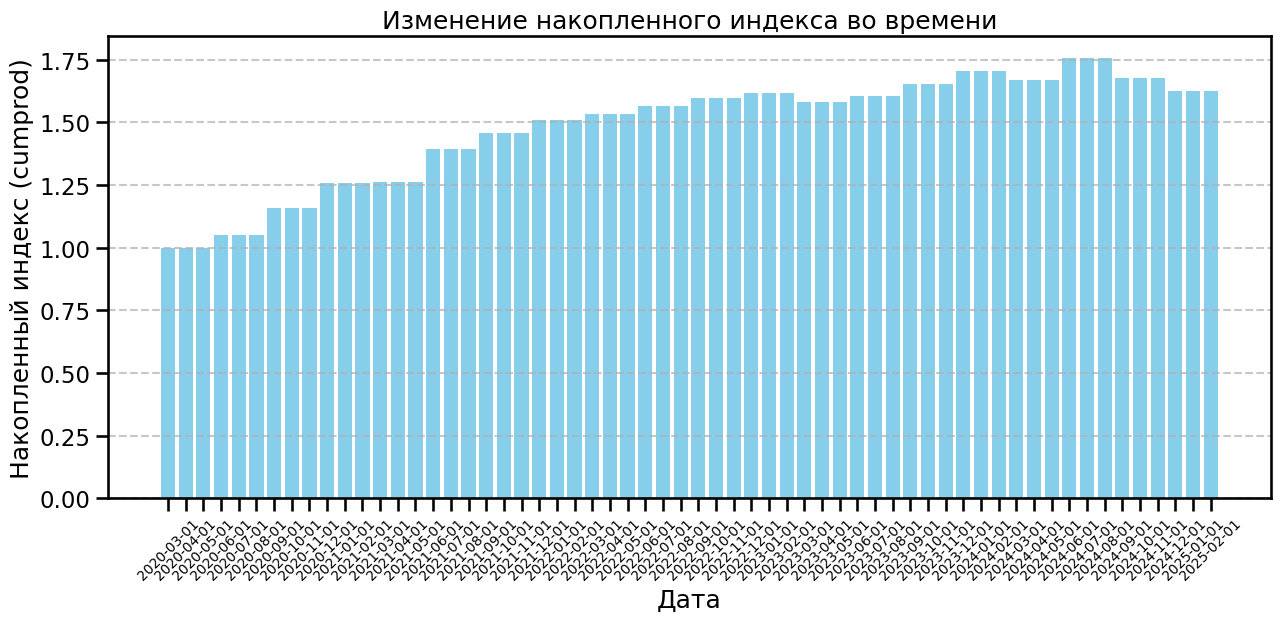

In [59]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))  # Устанавливаем размер графика

# Строим столбчатую диаграмму
plt.bar(merged_table["reportDate"], merged_table["cumprod_y"], color="skyblue")

# # Форматируем ось X, чтобы даты отображались правильно
# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Автоматический интервал для дат
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  # Формат YYYY-MM

# Дополнительные настройки
plt.xticks(rotation=45, fontsize=10)  # Поворачиваем подписи на оси X для удобства
plt.xlabel("Дата")
plt.ylabel("Накопленный индекс (cumprod)")
plt.title("Изменение накопленного индекса во времени")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("index", dpi=300)
plt.show()


## Парсинг

1 - 45 Университет Дружбы народов

46 - 69 Генерала Тюленева

70 - 91 Генерала Тюленева + Тютчевская

92 - Потапово

In [162]:
urls_prices = [
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1697035&roomsCount=all&period=all", 
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=34441&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56706&roomsCount=all&period=all",        
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18008&roomsCount=all&period=all",                
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56710&roomsCount=all&period=all",        
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=71098&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=47492&roomsCount=all&period=all",     
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=989953&roomsCount=all&period=all",    
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=71097&roomsCount=all&period=all",  
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=71099&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=3245139&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18007&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58805&roomsCount=all&period=all",                  
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1080888&roomsCount=all&period=all",            
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56705&roomsCount=all&period=all", 
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=47490&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18000&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17997&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=606455&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1701671&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17998&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=32592&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58801&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1711316&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58806&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58795&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1695695&roomsCount=all&period=all",    
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18013&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79556&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79557&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1713733&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1715736&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1704699&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79567&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79561&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79525&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79570&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79569&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79572&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79539&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1703841&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1696643&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17957&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1715434&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17956&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1724532&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1703284&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1695949&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1700137&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1781723&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=606384&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17945&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1691421&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41145&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1702798&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1713741&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1695987&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41147&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79549&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79540&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79533&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79548&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79547&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79545&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41159&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1847202&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1803888&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1833802&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1873062&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1807554&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1864728&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1813861&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1096058&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1769520&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1870385&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18009&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=32599&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17996&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58813&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1707726&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56654&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=972356&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1850461&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1848324&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1846881&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1869028&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1873180&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1893398&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1831914&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41162&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79514&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79515&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1768971&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41157&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79562&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1803178&roomsCount=all&period=all",
    #"https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79567&roomsCount=oneRoom&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79528&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1697086&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=32593&roomsCount=all&period=all",

    
    ]

In [79]:

"https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58801&roomsCount=all&period=all" in urls_prices

True

In [163]:
urls_house_info = [
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+6&totalArea=38.4&roomsCount=1&offerId=309089270&floor=floorOther&repairType=repairTypeDesign",                                                                                   
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C+2%D0%9A1&totalArea=60.0&roomsCount=3&offerId=311850058&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A3&totalArea=52.5&roomsCount=3&offerId=307635407&floor=floorOther&repairType=repairTypeWithout",                                                                                                       
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+25%D0%9A1&totalArea=33.0&roomsCount=1&offerId=307458577&floor=floorOther&repairType=repairTypeWithout",                                                              
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A7&totalArea=75.9&roomsCount=3&offerId=310793059&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+4%D0%9A3&totalArea=81.1&roomsCount=3&offerId=309936581&floor=floorOne&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%9C%D0%B8%D0%BA%D0%BB%D1%83%D1%85%D0%BE-%D0%9C%D0%B0%D0%BA%D0%BB%D0%B0%D1%8F+%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C+27%D0%9A1&totalArea=73.8&roomsCount=3&offerId=308129789&floor=floorOther&repairType=repairTypeWithout",                                               
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+8%D0%BA3&totalArea=58.0&roomsCount=2&offerId=309527570&floor=floorOther&repairType=repairTypeWithout",                                                                         
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+4%D0%9A2&totalArea=79.5&roomsCount=3&offerId=309254865&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+4%D0%9A4&totalArea=55.2&roomsCount=2&offerId=308290049&floor=floorLast&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+2%D0%90&totalArea=120.0&roomsCount=3&offerId=309980787&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+23%D0%9A1&totalArea=60.0&roomsCount=3&offerId=306765780&floor=floorOne&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+9%D0%9A4&totalArea=39.0&roomsCount=1&offerId=307912564&floor=floorLast&repairType=repairTypeEuro",                                                     
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%BA6&totalArea=41.0&roomsCount=1&offerId=311945204&floor=floorOther&repairType=repairTypeEuro",                                                                                     
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A2&totalArea=71.6&roomsCount=4&offerId=311912659&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%9C%D0%B8%D0%BA%D0%BB%D1%83%D1%85%D0%BE-%D0%9C%D0%B0%D0%BA%D0%BB%D0%B0%D1%8F+%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C+25&totalArea=38.7&roomsCount=1&offerId=310270512&floor=floorLast&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+15%D0%9A3&totalArea=66.4&roomsCount=3&offerId=311328806&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+15%D0%9A1&totalArea=63.0&roomsCount=3&offerId=300302109&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+8%D0%90&totalArea=95.1&roomsCount=3&offerId=311908456&floor=floorTwo&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+13&totalArea=45.3&roomsCount=2&offerId=307780981&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+15%D0%9A2&totalArea=45.0&roomsCount=2&offerId=299209036&floor=floorTwo&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C+2%D0%9A1&totalArea=40.0&roomsCount=1&offerId=309589901&floor=floorTwo&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+9%D0%9A1&totalArea=52.5&roomsCount=1&offerId=308770205&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C+8&totalArea=45.8&roomsCount=2&offerId=311262176&floor=floorLast&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+9%D0%9A5&totalArea=120.0&roomsCount=3&offerId=303870632&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+5%D0%9A3&totalArea=51.0&roomsCount=1&offerId=311125656&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+9&totalArea=66.6&roomsCount=2&offerId=311234104&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+31%D0%9A2&totalArea=64.0&roomsCount=3&offerId=310639393&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+21%D0%9A1&totalArea=75.0&roomsCount=3&offerId=303230896&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+21%D0%9A2&totalArea=26.0&roomsCount=1&offerId=308076419&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+4&totalArea=50.6&roomsCount=2&offerId=310662654&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+8&totalArea=59.0&roomsCount=3&offerId=310505447&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+23&totalArea=36.8&roomsCount=1&offerId=311772311&floor=floorLast&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+25%D0%9A1&totalArea=37.6&roomsCount=1&offerId=310947195&floor=floorLast&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+21%D0%9A5&totalArea=45.2&roomsCount=2&offerId=312120809&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+12%D0%9A1&totalArea=38.5&roomsCount=2&offerId=310625201&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+25%D0%9A5&totalArea=45.0&roomsCount=2&offerId=308637655&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+25%D0%9A4&totalArea=62.0&roomsCount=3&offerId=288824068&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+27&totalArea=54.0&roomsCount=2&offerId=311120890&floor=floorLast&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+14%2F2&totalArea=44.4&roomsCount=2&offerId=301200222&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+5&totalArea=76.2&roomsCount=4&offerId=308144018&floor=floorOne&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+3&totalArea=60.8&roomsCount=3&offerId=302971287&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+4%D0%9A2&totalArea=40.0&roomsCount=2&offerId=310967629&floor=floorOther",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+6&totalArea=60.0&roomsCount=3&offerId=308397152&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+4%D0%9A1&totalArea=34.1&roomsCount=1&offerId=305930485&floor=floorOne&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+12&totalArea=50.8&roomsCount=2&offerId=304858455&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+1&totalArea=102.2&roomsCount=3&offerId=311371966&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+6&totalArea=45.2&roomsCount=2&offerId=308908363&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+2&totalArea=32.5&roomsCount=1&offerId=312295732&floor=floorOne&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+8&totalArea=65.6&roomsCount=3&offerId=312454781&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+28&totalArea=32.6&roomsCount=1&offerId=307775309&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+36&totalArea=73.4&roomsCount=3&offerId=311208660&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+11&totalArea=64.0&roomsCount=3&offerId=310743428&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+7%D0%9A1&totalArea=61.0&roomsCount=3&offerId=311126074&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+13&totalArea=68.0&roomsCount=3&offerId=304856437&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+15&totalArea=51.3&roomsCount=2&offerId=311160192&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+17&totalArea=51.0&roomsCount=2&offerId=302404390&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+7%D0%9A2&totalArea=34.7&roomsCount=1&offerId=308231609&floor=floorTwo&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A7&totalArea=52.0&roomsCount=2&offerId=309113077&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A1&totalArea=63.5&roomsCount=2&offerId=301855337&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+13%D0%9A1&totalArea=58.8&roomsCount=2&offerId=308746096&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A6&totalArea=51.5&roomsCount=2&offerId=309117903&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A5&totalArea=61.5&roomsCount=3&offerId=294319016&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A4&totalArea=34.8&roomsCount=1&offerId=312464277&floor=floorOne&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+25&totalArea=51.5&roomsCount=2&offerId=309890288&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D1%80%D0%BE%D1%8F+%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8+%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C+1&totalArea=67.4&roomsCount=2&offerId=309636118&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D1%80%D0%BE%D1%8F+%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8+%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C+18&totalArea=50.5&roomsCount=1&offerId=310314749&floor=floorTwo&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+35&totalArea=54.0&roomsCount=1&offerId=312231467&floor=floorTwo&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+31&totalArea=44.9&roomsCount=2&offerId=308567781&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+33&totalArea=51.4&roomsCount=2&offerId=303243667&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+28&totalArea=33.3&roomsCount=1&offerId=307890576&floor=floorTwo&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+29&totalArea=33.9&roomsCount=1&offerId=311586464&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%9E%D0%BF%D0%B0%D1%80%D0%B8%D0%BD%D0%B0%2C+4%D0%BA1&totalArea=54.0&roomsCount=1&offerId=313034357&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+19&totalArea=65.0&roomsCount=3&offerId=312577524&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+17&totalArea=36.0&roomsCount=1&offerId=313352960&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+25%D0%9A2&totalArea=64.0&roomsCount=3&offerId=313715861&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C+5%D0%9A1&totalArea=41.8&roomsCount=2&offerId=313486539&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+14%D0%9A3&totalArea=75.6&roomsCount=3&offerId=307390635&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+11%D0%9A1&totalArea=120.0&roomsCount=4&offerId=303619557&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+18&totalArea=70.3&roomsCount=4&offerId=312890563&floor=floorOther",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+4%D0%9A1&totalArea=44.6&roomsCount=2&offerId=303885699&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%9B%D0%B5%D0%BD%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D0%B9+%D0%BF%D1%80%D0%BE%D1%81%D0%BF%D0%B5%D0%BA%D1%82%2C+111%D0%BA1&totalArea=161.1&roomsCount=3&offerId=302152670&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D1%80%D0%BE%D1%8F+%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8+%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C+17&totalArea=67.3&roomsCount=3&offerId=312621729&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D1%80%D0%BE%D1%8F+%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8+%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C+7&totalArea=47.1&roomsCount=2&offerId=313145420&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D1%80%D0%BE%D1%8F+%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8+%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C+5&totalArea=60.0&roomsCount=3&offerId=312946294&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D0%BF%D1%80%D0%BE%D0%B5%D0%B7%D0%B4+%D0%9C%D1%83%D0%B7%D1%8B%D0%BA%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9%2C+2&totalArea=63.0&roomsCount=3&offerId=309757665&floor=floorOne&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+24&totalArea=64.1&roomsCount=3&offerId=313274507&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+16&totalArea=33.2&roomsCount=1&offerId=302189887&floor=floorOne&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+15&totalArea=60.3&roomsCount=3&offerId=309818928&floor=floorLast&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+27&totalArea=52.1&roomsCount=2&offerId=302329954&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+9%D0%9A6&totalArea=60.1&roomsCount=3&offerId=312759234&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+9%D0%9A7&totalArea=55.0&roomsCount=2&offerId=309582779&floor=floorTwo&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+3&totalArea=51.0&roomsCount=2&offerId=313645435&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+23%D0%9A1&totalArea=34.9&roomsCount=1&offerId=313640883&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+21%D0%9A6&totalArea=35.8&roomsCount=1&offerId=312986899&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+6&totalArea=44.2&roomsCount=2&offerId=313426885&floor=floorOther&repairType=repairTypeCosmetic",
    #"https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+25%D0%9A1&totalArea=37.5&roomsCount=1&offerId=313504727&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+12%D0%9A4&totalArea=49.8&roomsCount=3&offerId=313168066&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+18&totalArea=52.0&roomsCount=2&offerId=313728416&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C+2%D0%9A2&totalArea=43.0&roomsCount=2&offerId=313737828&floor=floorOther&repairType=repairTypeCosmetic",
    
    
]   

In [164]:
urls_metro = [
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%206",                                                            
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C%202%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A3",                                                                                   
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2025%D0%9A1",                                        
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A7",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%204%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%9C%D0%B8%D0%BA%D0%BB%D1%83%D1%85%D0%BE-%D0%9C%D0%B0%D0%BA%D0%BB%D0%B0%D1%8F%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C%2027%D0%9A1",                              
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%208%D0%BA3",                                                             
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%204%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%204%D0%9A4",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%202%D0%90",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2023%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%209%D0%9A4",                      
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%BA6",                                                                            
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%9C%D0%B8%D0%BA%D0%BB%D1%83%D1%85%D0%BE-%D0%9C%D0%B0%D0%BA%D0%BB%D0%B0%D1%8F%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C%2025",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2015%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2015%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%208%D0%90",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2013",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2015%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C%202%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%209%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C%208",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%209%D0%9A5",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%205%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%209",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2031%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2021%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2021%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%204",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%208",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2023",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2025%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2021%D0%9A5",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2012%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2025%D0%9A5",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2025%D0%9A4",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2027",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2014%2F2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%205",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%203",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%204%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%206",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%204%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%2012",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%201",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%206",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%202",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%208",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%2028",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%2036",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2011",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%207%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2013",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2015",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2017",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%207%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A7",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2013%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A6",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A5",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A4",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2025",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D1%80%D0%BE%D1%8F%20%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8%20%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C%201",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D1%80%D0%BE%D1%8F%20%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8%20%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C%2018",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2035",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2031",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2033",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2028",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2029",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%9E%D0%BF%D0%B0%D1%80%D0%B8%D0%BD%D0%B0%2C%204%D0%BA1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2019",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2017",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2025%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C%205%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2014%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%2011%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2018",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%204%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%9B%D0%B5%D0%BD%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D0%B9%20%D0%BF%D1%80%D0%BE%D1%81%D0%BF%D0%B5%D0%BA%D1%82%2C%20111%D0%BA1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D1%80%D0%BE%D1%8F%20%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8%20%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C%2017",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D1%80%D0%BE%D1%8F%20%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8%20%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C%207",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D1%80%D0%BE%D1%8F%20%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8%20%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C%205",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D0%BF%D1%80%D0%BE%D0%B5%D0%B7%D0%B4%20%D0%9C%D1%83%D0%B7%D1%8B%D0%BA%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9%2C%202",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2024",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2016",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2015",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2027",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%209%D0%9A6",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%209%D0%9A7",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%203",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2023%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2021%D0%9A6",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%206",
    #"https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2025%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2012%D0%9A4",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%2018",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C%202%D0%9A2",

]

In [100]:


# Словарь для хранения индексов повторяющихся элементов
repeated_indices = {}

for idx, value in enumerate(urls_prices):
    if urls_prices.count(value) > 1:
        repeated_indices.setdefault(value, []).append(idx)

print(repeated_indices)  # {1: [0, 7, 9], 2: [1, 4], 3: [2, 5]}


{}


### Парсим цены

In [172]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

all_data = []

def fetch_and_process_url(url, realty_id):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            data = response.json()  
            if 'houseTrand' in data:
                trend_data = pd.DataFrame(data['houseTrand'])
                trend_data['value'] = trend_data['value'].astype(float)
                trend_data['reportDate'] = pd.to_datetime(trend_data['reportDate'])
                trend_data['realty_id'] = realty_id 
                return trend_data
            else:
                print(f"Ключ 'houseTrand' отсутствует в ответе для {url}")
        else:
            print(f"Ошибка {response.status_code} при запросе {url}")
    except requests.RequestException as e:
        print(f"Ошибка при запросе {url}: {e}")
    return None

for idx, url in enumerate(urls_prices, start=1):
    print(f"Обработка ссылки {idx}/{len(urls_prices)}: {url}")
    trend_data = fetch_and_process_url(url, realty_id=idx)
    if trend_data is not None:
        all_data.append(trend_data)
    
    pause = random.uniform(30, 33)
    print(f"Пауза {pause:.2f} секунд...")
    time.sleep(pause)

if all_data:
    prices_data = pd.concat(all_data, ignore_index=True)
    prices_data

Обработка ссылки 1/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1697035&roomsCount=all&period=all
Пауза 30.25 секунд...
Обработка ссылки 2/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=34441&roomsCount=all&period=all
Пауза 30.63 секунд...
Обработка ссылки 3/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56706&roomsCount=all&period=all
Пауза 30.16 секунд...
Обработка ссылки 4/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18008&roomsCount=all&period=all
Пауза 33.00 секунд...
Обработка ссылки 5/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56710&roomsCount=all&period=all
Пауза 31.31 секунд...
Обработка ссылки 6/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=71098&roomsCount=all&period=all
Пауза 31.66 секунд...
Обработка ссылки 7/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?real

In [173]:
prices_data.shape

(4497, 4)

In [120]:
prices_data

,value,reportDate,prettyValue,realty_id
0,220493.0,2020-03-01,220 493 ₽/м²,1
1,228764.0,2020-04-01,228 764 ₽/м²,1
2,228764.0,2020-05-01,228 764 ₽/м²,1
3,239315.0,2020-06-01,239 315 ₽/м²,1
4,236383.0,2020-07-01,236 383 ₽/м²,1
...,...,...,...,...
4523,333333.0,2024-06-01,333 333 ₽/м²,100
4524,333333.0,2024-07-01,333 333 ₽/м²,100
4525,322222.0,2024-08-01,322 222 ₽/м²,100
4526,322222.0,2024-09-01,322 222 ₽/м²,100


In [175]:
prices_data.to_csv("prices_data.csv", index=False)

<hr>

### Парсим характеристики дома

In [174]:
columns = [
    "realty_id", "Адрес", "Год постройки", "Тип дома", "Этажность", "Строительная серия", "Высота потолков",
    "Газоснабжение", "Отопление", "Тип перекрытий", "Подъездов", "Количество лифтов",
    "Мусоропроводов", "Квартир", "Реновация", "Аварийность", "Детская площадка",
    "Спортивная площадка", "Фонд капитального ремонта", "URL"
]
data_house_features = pd.DataFrame(columns=columns)


def parse_page(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code != 200:
            print(f"Ошибка загрузки страницы: {response.status_code} для {url}")
            return None

        soup = BeautifulSoup(response.text, "html.parser")


        address_block = soup.find("span", class_="f0b5faa8cb--color_gray60_100--mYFjS")
        address = address_block.text.strip() if address_block else "Адрес не найден"

        name_blocks = soup.find_all("div", class_="f0b5faa8cb--name--vfsqB")
        value_blocks = soup.find_all("div", class_="f0b5faa8cb--val--YiBYQ")

        if len(name_blocks) == len(value_blocks):
            data = {"Адрес": address, "URL": url}  
            for name, value in zip(name_blocks, value_blocks):
                key = name.text.strip()
                val = value.text.strip()
                data[key] = val
            return data
        else:
            print(f"Количество названий и значений не совпадает для {url}.")
            return None
    except requests.RequestException as e:
        print(f"Ошибка при запросе {url}: {e}")
        return None


parsed_data_list = []
for idx, url in enumerate(urls_house_info, start=1): 
    print(f"Обработка {idx}/{len(urls_house_info)}: {url}")
    parsed_data = parse_page(url)
    if parsed_data:
        parsed_data["realty_id"] = idx  
        
        for col in columns:
            if col not in parsed_data:
                parsed_data[col] = None
        parsed_data_list.append(parsed_data)
    
   
    pause = random.uniform(30, 33)
    print(f"Пауза {pause:.2f} секунд...")
    time.sleep(pause)


if parsed_data_list:
    data_house_features = pd.concat([pd.DataFrame([data]) for data in parsed_data_list], ignore_index=True)
    print("Данные успешно собраны.")
else:
    print("Нет данных для объединения.")

Обработка 1/99: https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+6&totalArea=38.4&roomsCount=1&offerId=309089270&floor=floorOther&repairType=repairTypeDesign
Пауза 31.45 секунд...
Обработка 2/99: https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C+2%D0%9A1&totalArea=60.0&roomsCount=3&offerId=311850058&floor=floorOther&repairType=repairTypeDesign
Пауза 32.74 секунд...


Обработка 3/99: https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A3&totalArea=52.5&roomsCount=3&offerId=307635407&floor=floorOther&repairType=repairTypeWithout
Пауза 32.22 секунд...
Обработка 4/99: https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+25%D0%9A1&totalArea=33.0&roomsCount=1&offerId=307458577&floor=floorOther&repairType=repairTypeWithout
Пауза 30.37 секунд...
Обработка 5/99: https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A7&totalArea=75.9&roomsCount=3&offerId=310793059&floor=floorOther&repairType=repairTypeCosmetic
Пауза 32.10 секунд...

In [176]:
data_house_features.shape

(99, 20)

In [177]:
data_house_features.to_csv("house_features.csv", index=False)

### Парсим расстояние до метро

In [179]:

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

all_metro_data = []


def fetch_and_process_metro(url, realty_id):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            data = response.json()  
            if 'metro' in data:  
                metro_list = data['metro']
                metro_data = []
                for metro in metro_list:
                    metro_data.append({
                        "Станция": metro["name"],
                        "Расстояние (м)": metro["distance"],
                        "Тип транспорта": "Пешком" if metro["travelType"] == "byFoot" else "На машине",
                        "Время в пути (мин)": metro["travelTime"],
                        "realty_id": realty_id
                    })
                return pd.DataFrame(metro_data)
            else:
                print(f"Ключ 'metro' отсутствует в ответе для {url}")
        else:
            print(f"Ошибка {response.status_code} при запросе {url}")
    except requests.RequestException as e:
        print(f"Ошибка при запросе {url}: {e}")
    return None

for idx, url in enumerate(urls_metro, start=1):
    print(f"Обработка ссылки {idx}/{len(urls_metro)}: {url}")
    metro_data = fetch_and_process_metro(url, realty_id=idx)
    if metro_data is not None:
        all_metro_data.append(metro_data)
    
    
    pause = random.uniform(30, 35)
    print(f"Пауза {pause:.2f} секунд...")
    time.sleep(pause)


if all_metro_data:
    metro_data = pd.concat(all_metro_data, ignore_index=True)
    print("Данные о метро успешно собраны.")
else:
    metro_data = pd.DataFrame()  
    print("Нет данных для объединения.")

print(metro_data)


Обработка ссылки 1/99: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%206
Пауза 34.68 секунд...
Обработка ссылки 2/99: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C%202%D0%9A1
Пауза 32.70 секунд...
Обработка ссылки 3/99: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A3
Пауза 32.69 секунд...
Обработка ссылки 4/99: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90

In [180]:
metro_data.to_csv("metro_data.csv", index=False)

In [184]:
metro_data.shape

(297, 5)

In [181]:
# Группируем по realty_id и выбираем 3 ближайшие станции
nearest_stations = (
    metro_data.sort_values(by=["realty_id", "Расстояние (м)"])
    .groupby("realty_id")
    .head(3)  # Берем три ближайшие станции
    .reset_index(drop=True)
)

# Преобразуем данные в нужный формат
result = nearest_stations.pivot_table(
    index="realty_id",
    values=["Расстояние (м)", "Станция"],
    aggfunc=lambda x: list(x)[:3]  # Берем значения для трёх ближайших станций
).reset_index()

# Разделяем расстояния и названия станций по столбцам
result[["Расстояние до первой станции", "Расстояние до второй станции", "Расстояние до третьей станции"]] = pd.DataFrame(result["Расстояние (м)"].tolist(), index=result.index)
result[["Название первой станции", "Название второй станции", "Название третьей станции"]] = pd.DataFrame(result["Станция"].tolist(), index=result.index)

# Убираем лишние столбцы
result = result.drop(columns=["Расстояние (м)", "Станция"])

# Задаем список станций для исключения
excluded_stations = ["Университет Дружбы Народов", "Тютчевская", "Генерала Тюленева"]

# Находим ближайшую станцию для каждого объекта
nearest_station = (
    metro_data.sort_values(by=["realty_id", "Расстояние (м)"])
    .groupby("realty_id")
    .first()
    .reset_index()
    .rename(columns={"Расстояние (м)": "Ближайшая станция после тритмента расстояние", "Станция": "Ближайшая станция после тритмента"})
)

# Находим ближайшую станцию, которая не входит в исключения
filtered_stations = (
    metro_data[~metro_data["Станция"].isin(excluded_stations)]
    .sort_values(by=["realty_id", "Расстояние (м)"])
    .groupby("realty_id")
    .first()
    .reset_index()
    .rename(columns={"Расстояние (м)": "Ближайшая станция до тритмента расстояние", 
                     "Станция": "Ближайшая станция до тритмента"})
)

# Объединяем с данными о трёх ближайших станциях
result = result.merge(nearest_station[["realty_id", "Ближайшая станция после тритмента расстояние", "Ближайшая станция после тритмента"]], on="realty_id", how="left")
result = result.merge(filtered_stations[["realty_id", "Ближайшая станция до тритмента расстояние", "Ближайшая станция до тритмента"]], on="realty_id", how="left")

# Считаем разницу расстояний
result["Сокращение расстояния"] = (
    result["Ближайшая станция до тритмента расстояние"] - result["Ближайшая станция после тритмента расстояние"]
)

result.head()


,realty_id,Расстояние до первой станции,Расстояние до второй станции,Расстояние до третьей станции,Название первой станции,Название второй станции,Название третьей станции,Ближайшая станция после тритмента расстояние,Ближайшая станция после тритмента,Ближайшая станция до тритмента расстояние,Ближайшая станция до тритмента,Сокращение расстояния
0,1,881.0,2370.0,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0
1,2,1297.0,1311.0,1483.0,Университет Дружбы Народов,Калужская,Воронцовская,1297.0,Университет Дружбы Народов,1311.0,Калужская,14.0
2,3,978.0,1816.0,2680.0,Университет Дружбы Народов,Воронцовская,Новаторская,978.0,Университет Дружбы Народов,1816.0,Воронцовская,838.0
3,4,930.0,1169.0,1450.0,Университет Дружбы Народов,Беляево,Коньково,930.0,Университет Дружбы Народов,1169.0,Беляево,239.0
4,5,1060.0,1542.0,1752.0,Университет Дружбы Народов,Калужская,Воронцовская,1060.0,Университет Дружбы Народов,1542.0,Калужская,482.0


In [182]:
result.shape

(99, 12)

In [183]:
merged_table = prices_data.merge(data_house_features, on='realty_id', how='left').merge(result, on='realty_id', how='left')
merged_table.to_csv("merged_table.csv", index=False)